# Statistics Project #3 - Univariate Analysis
***

## Introduction
***

**Description**: This script uses one-way ANOVA and post-hoc t-tests to determine if three different classes of enzymes (oxidoreductases, transferases, and hydrolases) have significantly different turn-over rates (Kcats) in *M. tuberculosis*. <br>

**Assumption**: The enzyme turn-over rate is inversely related to the size of the transferred group from one substrate to another. Therefore, the EC class that transfers the smallest group will have the greatest mean Kcat value. <br>

**Hypothesis**: Mean Kcat values: enzymes in EC class #1 (oxidoreductases) > EC class #3 (hydrolases) > EC class #2 (transferases) <br>

-Oxidoreductases transfer a single atom (H or O) or an electron <br>

-Hydrolases transfer protons (H+) and hydroxy groups (-OH) from water <br>

-Transferases move functional groups larger than water <br>

## Analysis
***
### Loads libraries, clears global environment, sets working directory, and sizes all plots

In [1]:
library(tidyverse)
library(readxl)
library(ggfortify)
library(viridis)
library(multcomp)

rm(list = ls())

setwd('./')

options(repr.plot.width=6, repr.plot.height=4)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: viridisLite
Loading required package: mvtnorm
Loading required package: survival
Loading required package: TH.data
Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select


Attaching package: ‘TH.data’

The following object is masked from ‘package:MASS’:

    geyser



### Loads in absolute protein abundances and renames columns

In [2]:
file_name <- 'data/proteomics_TB_absolute.xlsx'

# Kcat: enzyme turnover rate (# of substrate conversions per unit time)
proteins <- read_excel(file_name, sheet='Kcat', na='[]')

proteins <- proteins %>%
  rename(EC_number = `EC number`,
         Kcat_med_all = `Median turnover frequency over all organisms (Brenda)`,
         Kcat_med_Mtb = `Median turnover frequency for Mtb (Brenda)`,
         Kcat_used = `Turnover frequency used for Vmax estimation`)

glimpse(proteins)  # Kcat type: dbl implies no characters (good)

Rows: 3,999
Columns: 5
$ Protein      <chr> "Rv2405", "Rv3014c", "Rv3062", "Rv3730c", "Rv3731", "Rv0…
$ EC_number    <chr> "EC:6.5.1.4", "EC:6.5.1.2", "EC:6.5.1.1", "EC:6.5.1.1", …
$ Kcat_med_all <dbl> 0.000, 0.041, 0.032, 0.032, 0.032, 1.450, 1.450, 1.450, …
$ Kcat_med_Mtb <dbl> 0.000, 0.072, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, …
$ Kcat_used    <dbl> 1.000, 0.072, 0.032, 0.032, 0.032, 1.450, 1.450, 1.450, …


### Subsets data (only proteins with EC classes 1, 2, or 3 are used)

In [3]:
proteins <- mutate(proteins, EC_class = substr(EC_number, 4, 4))

proteins$EC_class <- as.factor(proteins$EC_class)

EC_1_2_3 <- filter(proteins, EC_class == 1 | EC_class == 2 | EC_class == 3)

glimpse(EC_1_2_3)  # data types look good --> EC_class: fct, Kcat_used = dbl

Rows: 528
Columns: 6
$ Protein      <chr> "Rv0939", "Rv3569c", "Rv0969", "Rv1469", "Rv0092", "Rv19…
$ EC_number    <chr> "EC:3.7.1.2", "EC:3.7.1.-", "EC:3.6.3.5,EC:3.6.3.3,EC:3.…
$ Kcat_med_all <dbl> 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, …
$ Kcat_med_Mtb <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0…
$ Kcat_used    <dbl> 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, …
$ EC_class     <fct> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,…


Since I'll be looking for differences in Kcat means (y: continuous) across 3 EC
classes (x: categorical), an Analysis of Variance/One-way ANOVA (3+ variables/EC classes)
seems appropriate.


### Calculates median, mean, stnd. dev. and stnd. error for each EC class.

In [4]:
Kcat_md_mn_sd_se <- EC_1_2_3 %>% group_by(EC_class) %>%
  summarise(medianKcat = median(Kcat_used),
            meanKcat = mean(Kcat_used),
            sdKcat = sd(Kcat_used),
            n = n(), seKcat = sd(Kcat_used)/sqrt(n()))

Kcat_md_mn_sd_se

`summarise()` ungrouping output (override with `.groups` argument)


EC_class,medianKcat,meanKcat,sdKcat,n,seKcat
1,1.800,66.84955,203.6909,169,15.668529
2,1.000,20.76213,116.7516,231,7.681693
3,1.155,59.39015,356.5303,128,31.513122


**Analysis**: Ratio of largest to smallest stnd. dev. is ~3. ANOVA is appropriate for formal testing of means.


### Exploratory Plot: Histograms for each EC class

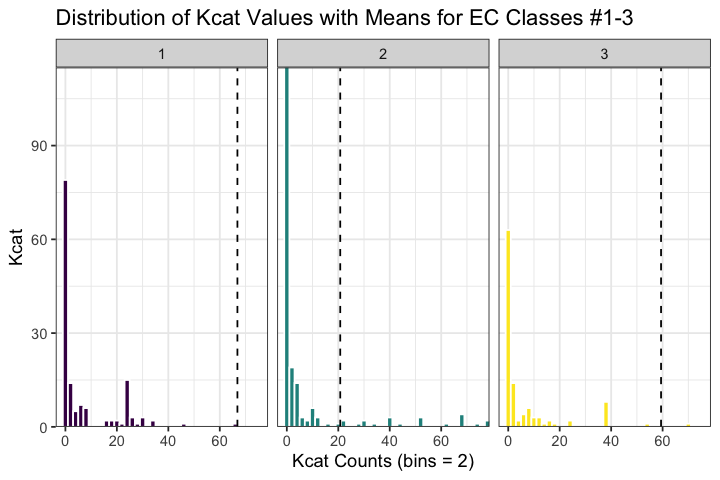

In [5]:
hist_t = 'Distribution of Kcat Values with Means for EC Classes #1-3'

ggplot(EC_1_2_3, aes(Kcat_used, fill=EC_class)) +
  geom_histogram(binwidth=2, color='white') +
  facet_wrap(~ EC_class) +
  geom_vline(data=Kcat_md_mn_sd_se, aes(xintercept=meanKcat),
             linetype='dashed') +
  labs(title=hist_t, x='Kcat Counts (bins = 2)', y='Kcat') +
  scale_fill_viridis(discrete=TRUE, option='viridis') +
  scale_y_continuous(expand=c(0, 0)) +
  theme_bw() + theme(legend.position='none') + coord_cartesian(xlim=c(0,75), ylim=c(0, 115))

**Analysis**: Distribution is right-skewed and 0-bounded for each EC class (common for abundance data) --> log10-transform then assess residuals


### Log-10 transforms Kcat values then calculates median, mean, stnd. dev. and stnd. error for each EC class

In [6]:
Kcat_md_mn_sd_se_log <- EC_1_2_3 %>% group_by(EC_class) %>%
  summarise(medianKcat = median(log10(Kcat_used)),
            meanKcat = mean(log10(Kcat_used)),
            sdKcat = sd(log10(Kcat_used)),
            n = n(), seKcat = sd(log10(Kcat_used))/sqrt(n()))

Kcat_md_mn_sd_se_log

`summarise()` ungrouping output (override with `.groups` argument)


EC_class,medianKcat,meanKcat,sdKcat,n,seKcat
1,0.25527251,0.6487153,1.0373418,169,0.07979553
2,0.00000000,0.1525844,0.9590766,231,0.06310261
3,0.06225211,0.4716528,1.1171162,128,0.09874006


### Creates linear model for ANOVA and checks residuals
**Normal distribution & equal variance assumptions must be met to continue with ANOVA model**

Warning message:
“`arrange_()` is deprecated as of dplyr 0.7.0.
Please use `arrange()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”Warning message:
“Removed 528 row(s) containing missing values (geom_path).”Warning message:
“Removed 528 row(s) containing missing values (geom_path).”

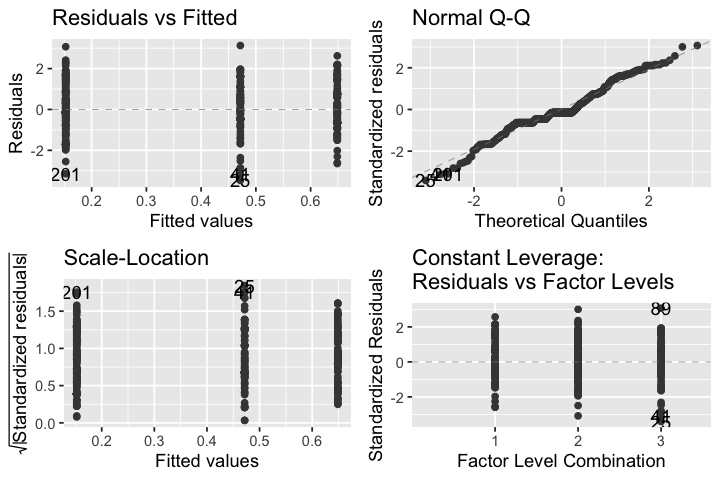

In [7]:
model_Kcat_log <- lm(log10(Kcat_used) ~ EC_class, data = EC_1_2_3)

autoplot(model_Kcat_log, smooth.colour = NA)

**Analysis**: distribution of residuals for log10-transformed values is symmetric <br>
-no patterns in R vs. F or S-L, normal QQ line matches theoretical (few outliers at low and high end), no outliers skewing data in R vs. FLs


### Runs ANOVA
**Answers: "Are Kcat means distinguishable/significantly different from one another based on EC class?"**

In [8]:
anova(model_Kcat_log)  # significance level (α) defaults to 5% 

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
EC_class,2,25.18492,12.592462,12.00194,8.003316e-06
Residuals,525,550.83103,1.049202,NA,NA


**Analysis**: In this *M. tuberculosis* study profiling proteomic expression at different stages of infection, enzyme turnover rates (Kcat) in EC classes 1, 2, and 3 have significantly different means (F = 12, df = 2,525, p-value < 0.0001).


***Since ANOVA only tells us there is a significant difference, we'll need to run a
post-hoc test to tell us the magnitude and direction of each difference between
EC classes.***

Pairwise t-test <br>
-x: categorical (EC_class), y: continuous (Kcat) <br>
-Rule of Thumb: If n ≥ 40, t-statistic generally safe to use, even with skewness <br>
-also, no possion glm (response variables must be integers, not floats) <br>

***Since we are testing more than one hypothesis, we need to minimize the chance of
falsely rejecting the Null Hypothesis (i.e. making a Type I error) by lowering
our sig. level/alpha***

In [9]:
summary(glht(model_Kcat_log, linfct = mcp(EC_class = 'Tukey')),
        test = adjusted('bonferroni'))


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lm(formula = log10(Kcat_used) ~ EC_class, data = EC_1_2_3)

Linear Hypotheses:
           Estimate Std. Error t value Pr(>|t|)    
2 - 1 == 0  -0.4961     0.1037  -4.785 6.68e-06 ***
3 - 1 == 0  -0.1771     0.1200  -1.475   0.4222    
3 - 2 == 0   0.3191     0.1129   2.827   0.0146 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- bonferroni method)


# Conclusion
***
**The Bonferroni adjusted p-values tell us: <br>
<br>
There is a significantly lower mean enzyme turnover rate (Kcat) for EC Class 2/transferases versus EC Class 1/oxidoreductases (t = -4.785, df = 398, p-value < 0.0001). <br>
<br>
There is no difference between mean Kcat values for EC Class 3/hydrolases versus EC Class 1/oxidoreductases (t = -1.475, df = 295, p-value = 0.4222). <br>
<br>
There is a significantly higher mean Kcat for EC Class 3/hydrolases verses EC Class 2/transferases (t = 2.827, df = 357, p-value = 0.0146).** <br>
<br>
**My overall hypothesis was partially correct. <br>
Hypothesis (Kcat): EC class 1 > EC class 3 > EC class 2 <br>
Result (Kcat):     EC class 1 = EC class 3 > EC class 2** <br>
<br>
### Final Plot: Boxplots with adjusted p-values and 95% confidence intervals

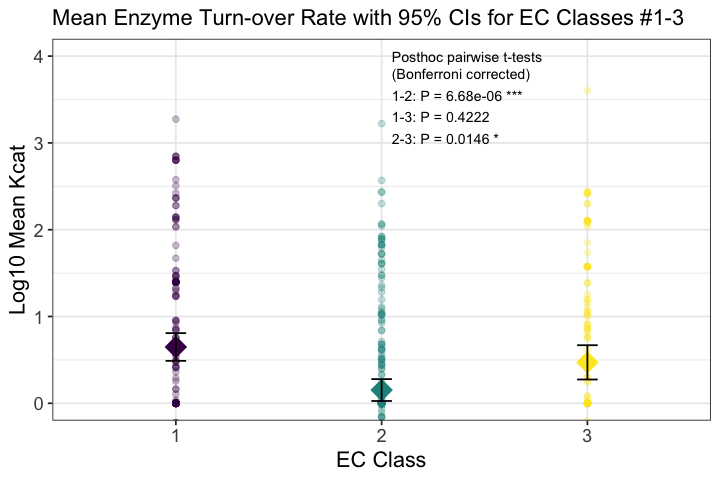

In [10]:
ggplot(data=EC_1_2_3) +
  geom_point(mapping=aes(x=EC_class, y=log10(Kcat_used),
                         colour=EC_class), size=1.5, alpha=0.25) +
  geom_point(data=Kcat_md_mn_sd_se_log,
             aes(x=EC_class, y=meanKcat, colour=EC_class), size=6, shape=18) +

  geom_errorbar(data=Kcat_md_mn_sd_se_log,
                aes(x=EC_class, ymin = meanKcat - 2*seKcat,
                    ymax = meanKcat + 2*seKcat), width = 0.1) +
  theme_bw() + theme(legend.position='none') +
  labs(title='Mean Enzyme Turn-over Rate with 95% CIs for EC Classes #1-3',
       x='EC Class', y='Log10 Mean Kcat') +
  scale_color_viridis(discrete = TRUE, option = 'viridis') +
  coord_cartesian(ylim=c(0, 4)) +
  theme(title=element_text(size=11),
        axis.text.x= element_text(size=11), 
        axis.title.x=element_text(size=13), 
        axis.text.y = element_text(size=11), 
        axis.title.y=element_text(size=13)) +
  annotate('text', x=2.05, y=4, label='Posthoc pairwise t-tests',
           hjust='left',  size=3) +
  annotate('text', x=2.05, y=3.8, label='(Bonferroni corrected)',
           hjust='left', size=3) +
  annotate('text', x=2.05, y=3.55, label='1-2: P = 6.68e-06 ***',
           hjust='left', size=3) +
  annotate('text', x=2.05, y=3.3, label='1-3: P = 0.4222',
           hjust='left', size=3) +
  annotate('text', x=2.05, y=3.05, label='2-3: P = 0.0146 *',
           hjust='left', size=3)

ggsave('plots/3_univariate_analysis.png', width=6, height=4, unit='in')